# This notebook explores how to train an MLP model to solve the Seismic task

##  1. Instantiating the datamodule object and preparing the data

Here the batch size is important to test out, if you have access to a memory rich gpu you can increase the batch size. If not decrease the batch size to avoid memory errors.

Training this model in cpu is not recommended as it will take a lot of time to train. If you don't have access to a gpu, you can use the kaggle or colab gpu notebooks to train the model.

In [1]:
from data_modules.seismic import SeismicDataModule

# Instantiating the HarDataModule with root dir at data/example
my_data_module = SeismicDataModule("data/", batch_size=4)

Data downloaded and extracted


## 2. Retrieving the training and validation set dataloaders

Besides defining the batch size, the data module manages the data loaders for the training, validation, and test partitions. 
The next command shows how to retrieve the training and validation data loaders.

In [2]:
# Retrieve the training set dataloader (dl)
train_dl = my_data_module.train_dataloader()
val_dl = my_data_module.val_dataloader()

## 3. Creating the ML model



In [3]:
from torchvision.models.segmentation import deeplabv3_resnet50

# Instantiating the model
model = deeplabv3_resnet50(num_classes=6)

print(model)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/vscode/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:04<00:00, 24.6MB/s]


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

## 4. Test the untrained model

First, lets test the model in a very detailed way, so we can inspect the shape of the tensors being processed and produced.
NOTE: the model has not been trained yet, hence, we expect very poor results.


-- Processing the batch 0
 predictions.shape =  torch.Size([4, 1, 255, 701])
Labels shape =  torch.Size([4, 1, 255, 701])
 predictions =  tensor([[[[0, 0, 0,  ..., 2, 2, 2],
          [0, 0, 0,  ..., 2, 2, 2],
          [0, 0, 0,  ..., 2, 2, 2],
          ...,
          [5, 5, 5,  ..., 3, 3, 3],
          [5, 5, 5,  ..., 3, 3, 3],
          [5, 5, 5,  ..., 3, 3, 3]]],


        [[[2, 2, 2,  ..., 3, 3, 3],
          [2, 2, 2,  ..., 3, 3, 3],
          [2, 2, 2,  ..., 3, 3, 3],
          ...,
          [3, 3, 3,  ..., 2, 2, 2],
          [3, 3, 3,  ..., 2, 2, 2],
          [3, 3, 3,  ..., 2, 2, 2]]],


        [[[0, 0, 0,  ..., 3, 3, 3],
          [0, 0, 0,  ..., 3, 3, 3],
          [0, 0, 0,  ..., 3, 3, 3],
          ...,
          [0, 0, 0,  ..., 2, 2, 2],
          [0, 0, 0,  ..., 2, 2, 2],
          [0, 0, 0,  ..., 2, 2, 2]]],


        [[[3, 3, 3,  ..., 2, 2, 2],
          [3, 3, 3,  ..., 2, 2, 2],
          [3, 3, 3,  ..., 2, 2, 2],
          ...,
          [3, 3, 3,  ..., 3, 3, 3]

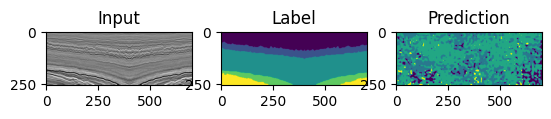

-- Processing the batch 1
batch IoU =  tensor(0.0506)


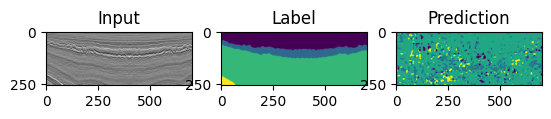

-- Processing the batch 2
batch IoU =  tensor(0.0502)


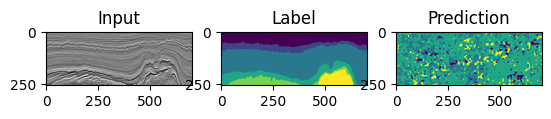

-- Processing the batch 3
batch IoU =  tensor(0.0493)


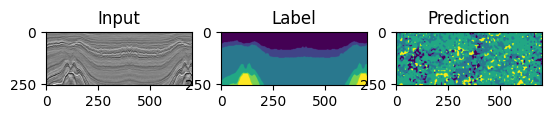

-- Processing the batch 4
batch IoU =  tensor(0.0537)


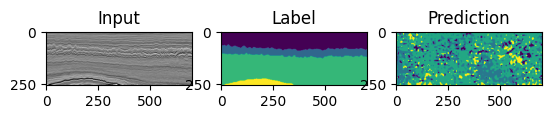

-- Processing the batch 5
batch IoU =  tensor(0.0480)


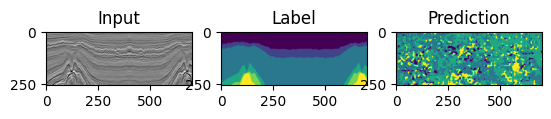

mIoU =  tensor(0.0499)


In [4]:
import torch
from matplotlib import pyplot as plt
from torchmetrics import JaccardIndex


# Initialize the JaccardIndex metric

jaccard = JaccardIndex(task="multiclass",num_classes=6)


# For each batch, compute the predictions and compare with the labels.


for batch_idx, (X, y) in enumerate(train_dl):

    print(f"-- Processing the batch {batch_idx}")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # X and y contains the input features and the expected labels for the B samples in the batch

    # Lets print their shape

    model.to(device) # Move the model to the GPU if available

    X = X.to(device) # Move the input data to the GPU if available

    logits = model(X.float())  # Convert input tensor to double precision

    predictions = torch.argmax(logits["out"], dim=1, keepdim=True) # The class with the highest logit is the prediction
    predictions = predictions.to("cpu")

    # printing the shape of the predictions tensor just for the first batch
    if batch_idx == 0:
        # Now, we have predictions for each one of the B input samples.
        # Lets print the shape of the predictions tensor and print the predictions themselves.
        print(" predictions.shape = ", predictions.shape)
        print("Labels shape = ", y.shape)

        print(" predictions = ", predictions)

        # Next, lets compare the predictions against the expected labels

        correct = (predictions == y)

        print(" labels      = ", y)

        print(" correct     = ", correct)

        # Finally, lets count the total number of correct predictions and the total number of predictions.

    iou = jaccard(predictions, y)
    print("batch IoU = ", iou)

    # lets plot the first sample in the batch and its corresponding label and prediction
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(X[0, 0, :, :].to("cpu").numpy(), cmap="gray")
    plt.title("Input")
    plt.subplot(1, 3, 2)
    plt.imshow(y[0, :, :].numpy().transpose(1, 2, 0))
    plt.title("Label")
    plt.subplot(1, 3, 3)
    plt.imshow(predictions[0, 0, :, :].numpy())
    plt.title("Prediction")
    plt.show()

    if batch_idx == 5:
        break


print("mIoU = ", jaccard.compute())

Take some time to inspect the output of the previous code block and make sure it makes sense.
Next, lets perform the same test, but without printing all the intermediate values.
We will also encapsulate the code in a function so we can reuse it later.

In [5]:
def evaluate_model(model, dataset_dl):
    # Inicialize JaccardIndex metric
    jaccard = JaccardIndex(task="multiclass", num_classes=6)

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # For each batch, compute the predictions and compare with the labels.
    for X, y in dataset_dl:
        # Move the model, data and metric to the GPU if available
        model.to(device)
        X = X.to(device)
        y = y.to(device)
        jaccard.to(device)

        logits = model(X.float())
        predictions = torch.argmax(logits["out"], dim=1, keepdim=True)
        jaccard(predictions, y)
    # Return a tuple with the number of correct predictions and the total number of predictions
    return (float(jaccard.compute().to("cpu")))

def report_accuracy(model, dataset_dl, prefix=""):
    iou = evaluate_model(model, dataset_dl)
    print(prefix + " IoU = {:0.4f}".format(iou))

In [6]:
report_accuracy(model, train_dl, prefix="Training dataset")
report_accuracy(model, val_dl, prefix="Validation dataset")

Training dataset IoU = 0.0512
Validation dataset IoU = 0.0516


## 5. Train the model

In this section, we will explore how a model is trained with pytorch.

First, lets define the optimizer and the loss function.

In [7]:
# We will employ pytorch SGD optimizer. We must provide it with the model parameters and the learning rate.
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

Now, lets instanciate the loss function. In this case, we will employ the pytorch CrossEntropyLoss function.

In [8]:
loss_fn = torch.nn.CrossEntropyLoss()

Training the model involves:

- Making predictions on the training samples.
- Calculating the gradients with respect to the loss functions.
- Adjusting the model parameters by applying the gradients scaled by the learning rate.

Lets first try it on a single batch.

In [9]:
# Fetch the first batch
first_batch = next(iter(train_dl))
# Fetch the first element on the batch (X_0, y_0)
X, y = first_batch
# Print the shape and contents of the batch
print("X.shape = ", X.shape)
print("y.shape = ", y.shape)

X.shape =  torch.Size([4, 3, 255, 701])
y.shape =  torch.Size([4, 1, 255, 701])


In [10]:
# Set the model in train mode -- this makes the forward pass store intermediate results that are required by the backward pass.

model.to(device)
X = X.to(device)
y = y.to(device)

model.train()

# Perform the predictions (forward pass)
logits = model(X.float())

predictions = logits["out"]

# Compute the loss
loss = loss_fn(predictions, y.squeeze(1).long())

# Reset the gradient values. The gradients are stored next to the model parameters, 
# on the same tensor objects, but on different attributes.
optimizer.zero_grad()

# Perform the backwards pass -- it computes and accumulates the gradients
loss.backward()

# Adjust the model weights according to the computed gradients and the learning rate.
optimizer.step()

# Evaluate the model
report_accuracy(model, train_dl)

 IoU = 0.3196


The previous code compute the gradients and updated the model weights using only a subset (a batch) of the training set. 

The next code shows how to train the model using all the batches and for multiple epochs. 
Notice that each epoch consists of training the model with all batches in the dataset (hence, the second loop).

In [11]:
number_of_epochs = 5

for epoch in range(number_of_epochs):
    print(f" ** Epoch {epoch} **")

    # Set the model in train mode. 
    model.train()

    for X,y in train_dl:
        X = X.to(device)
        y = y.to(device)
        # Perform the predictions (forward pass)
        logits = model(X.float())
        predictions = logits["out"]
        # Compute the loss
        loss = loss_fn(predictions, y.squeeze(1).long())
        # Reset the gradient values.
        optimizer.zero_grad()
        # Perform the backwards pass
        loss.backward()
        # Adjust the model weights according to the computed gradients and the learning rate.
        optimizer.step()
    
    # Set the model in evaluation mode for faster evaluation
    model.eval()
    report_accuracy(model, train_dl, prefix="   Training ")
    report_accuracy(model, val_dl, prefix="   Validation ")

 ** Epoch 0 **
   Training  IoU = 0.9269
   Validation  IoU = 0.9166
 ** Epoch 1 **
   Training  IoU = 0.9543
   Validation  IoU = 0.9482
 ** Epoch 2 **
   Training  IoU = 0.9613
   Validation  IoU = 0.9563
 ** Epoch 3 **
   Training  IoU = 0.9594
   Validation  IoU = 0.9537
 ** Epoch 4 **
   Training  IoU = 0.9675
   Validation  IoU = 0.9617


Here we are testing the model with a single batch, but we can also test the model with the entire validation set.

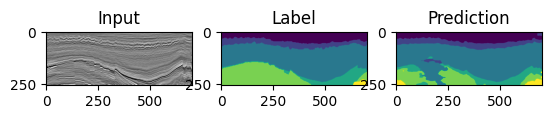

In [12]:
test_dl = my_data_module.test_dataloader()

first_batch = next(iter(test_dl))

X, y = first_batch

model.eval()

X = X.to(device)
y = y.to(device)

logits = model(X.float())

predictions = torch.argmax(logits["out"], dim=1, keepdim=True)

plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(X[0, 0, :, :].to("cpu").numpy(), cmap="gray")
plt.title("Input")
plt.subplot(1, 3, 2)
plt.imshow(y[0, :, :].to("cpu").numpy().transpose(1, 2, 0))
plt.title("Label")
plt.subplot(1, 3, 3)
plt.imshow(predictions[0, 0, :, :].to("cpu").numpy())
plt.title("Prediction")
plt.show()


Our model has been trained for 5 epochs. Notice that the training accuracy increased while the validation accuracy might have increased up to a point and then decreased again (hint: this might characterize overfitting). 

You might want to change the previous code to record the loss and accuracy values so you can plot them.

## 6. Train the model using [Pytorch Lightning](https://lightning.ai/docs/pytorch/stable/)

[Pytorch Lightning](https://lightning.ai/docs/pytorch/stable/) provides an API to facilitate training ML models with Pytorch.

Before continuing, please, read the [Lightning in 15 minues](https://lightning.ai/docs/pytorch/stable/starter/introduction.html) section of the PyTorch Lightning framework.

Lets create a LightningModule with our model.

In [13]:
import lightning as L

# define the lightning module to train our model
class LitModule(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.loss_fn = torch.nn.CrossEntropyLoss()

    def training_step(self, batch, batch_idx):
        # Training_step defines the train loop.
        # Just compute and return the loss. The trainer will take care of zeroing
        # the gradient, computing the gradients and updating the weights.
        X, y = batch
        logits = self.model(X.float())

        predictions = logits["out"]

        # Compute the loss
        loss = self.loss_fn(predictions, y.squeeze(1).long())
        # Logging to TensorBoard (if installed) by default
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
        return optimizer

In [14]:
# Create the model
model = deeplabv3_resnet50(num_classes=6)

# Create the lightning module and initialize it with our model.
lit_model = LitModule(model)

In [15]:
# Train the model
#  - We will use the train data loader
trainer = L.Trainer(max_epochs=5, log_every_n_steps=1)
trainer.fit(model=lit_model, train_dataloaders=train_dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | model   | DeepLabV3        | 39.6 M
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
39.6 M    Trainable params
0         Non-trainable params
39.6 M    Total params
158.540   Total estimated model params size (MB)
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 4: 100%|██████████| 248/248 [00:21<00:00, 11.68it/s, v_num=6]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 248/248 [00:21<00:00, 11.36it/s, v_num=6]


In [16]:
model = lit_model.model

model.eval()
report_accuracy(model, train_dl, prefix="   Training ")
report_accuracy(model, val_dl, prefix="   Validation ")

   Training  IoU = 0.9666
   Validation  IoU = 0.9614


#### Testing the model

Lets test the model with the test set and plot a inline to see the results.

   Test  IoU = 0.7484


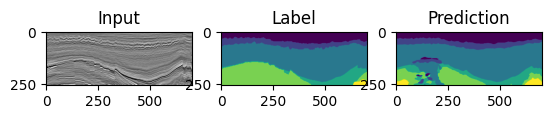

In [17]:
test_dl = my_data_module.test_dataloader()

report_accuracy(model, test_dl, prefix="   Test ")

first_batch = next(iter(test_dl))

X, y = first_batch

model.eval()

X = X.to(device)
y = y.to(device)

logits = model(X.float())

predictions = torch.argmax(logits["out"], dim=1, keepdim=True)

plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(X[0, 0, :, :].to("cpu").numpy(), cmap="gray")
plt.title("Input")
plt.subplot(1, 3, 2)
plt.imshow(y[0, :, :].to("cpu").numpy().transpose(1, 2, 0))
plt.title("Label")
plt.subplot(1, 3, 3)
plt.imshow(predictions[0, 0, :, :].to("cpu").numpy())
plt.title("Prediction")
plt.show()